In [12]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from utils import *

# Bin RSRP RSSI, RSRQ, SINR based on channel conditions.
In the part above, we segmentize using pd.cut(). But in the following, there are some RF-rules based on which awe segmentize the RSRP,RSRQ and SINR.

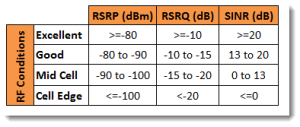

### N_RBs = RSRQ*RSSI/RSRP

In [2]:
# path = 'ns3NewData_/kpis_rand_maxbuff2500_01ms_ISD150_0speed_NewPL_20UEs.csv'
path = 'real_world_data/data_ready_ML.csv'
dfx = pd.read_csv(path).dropna()
dfx.drop(columns='PDCP_Thruput_DL', inplace =True)

# N = RSRQ*RSSI/RSRP => RSRQ+RSSI - RSRP
N = np.ceil(dfx['RSRQ']+dfx['RSSI']-dfx['RSRP']).astype(int)
dfx.insert(0, 'N_RBs', N)

# RSSI_new = dfx.RSRP - dfx.RSRQ # Removing the number of RBs. 
# dfx.insert(4, 'RSSI_new', RSSI_new)

dfx.head()

,N_RBs,RSRP,RSRQ,RSSI,PCC_SINR,PCC_PHY_Thruput_DL
0,15,-70.77,-8.66,-48.02,7.83,8737.41
1,15,-72.40,-10.56,-47.17,4.95,6969.09
2,15,-71.32,-10.13,-47.11,5.65,3874.06
3,15,-69.92,-9.62,-46.18,6.95,5575.82
4,15,-72.43,-10.30,-47.74,4.28,6114.99


<AxesSubplot:xlabel='RSRP', ylabel='RSSI'>

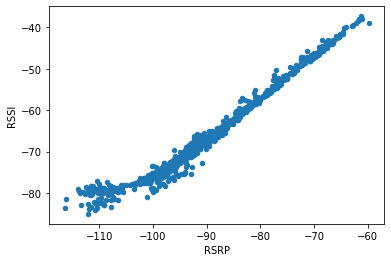

In [3]:
dfx.plot(x = 'RSRP', y = 'RSSI', kind = 'scatter')

<AxesSubplot:ylabel='Frequency'>

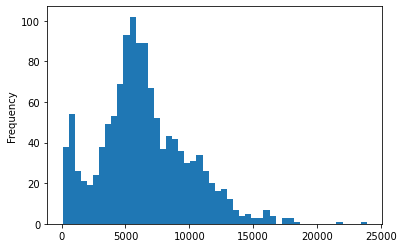

In [4]:
dfx.PCC_PHY_Thruput_DL.plot(kind = 'hist', bins = 50)

### There is a linear relationship between the RSSI and RSRP. <br>Hence we can remove the RSSI. <br>This will make our like much easier as we have one less variable to consider

In [5]:
df_binned = dfx.copy()

# 0: Excellent, 1: Good, 2: Mid-cell, 3: Cell Edge
df_binned['RSRP'] = np.where(df_binned['RSRP'] >= -80, 0, df_binned['RSRP'])
df_binned['RSRP'] = np.where((df_binned['RSRP'] < -80) & (df_binned['RSRP'] >= -90), 1, df_binned['RSRP'])
df_binned['RSRP'] = np.where((df_binned['RSRP'] < -90) & (df_binned['RSRP'] >= -100), 2, df_binned['RSRP'])
df_binned['RSRP'] = np.where(df_binned['RSRP'] <= -100 , 3, df_binned['RSRP'])

df_binned['RSRQ'] = np.where(df_binned['RSRQ'] >= -10, 0, df_binned['RSRQ'])
df_binned['RSRQ'] = np.where((df_binned['RSRQ'] < -10) & (df_binned['RSRQ'] >= -15), 1, df_binned['RSRQ'])
df_binned['RSRQ'] = np.where((df_binned['RSRQ'] < -15) & (df_binned['RSRQ'] >= -20), 2, df_binned['RSRQ'])
df_binned['RSRQ'] = np.where(df_binned['RSRQ'] < -20 , 3, df_binned['RSRQ'])

df_binned['PCC_SINR'] = np.where(df_binned['PCC_SINR'] >= 20, 0, df_binned['PCC_SINR'])
df_binned['PCC_SINR'] = np.where((df_binned['PCC_SINR'] < 20) & (df_binned['PCC_SINR'] > 13), 1, df_binned['PCC_SINR'])
df_binned['PCC_SINR'] = np.where((df_binned['PCC_SINR'] > 0) & (df_binned['PCC_SINR'] <= 13), 2, df_binned['PCC_SINR'])
df_binned['PCC_SINR'] = np.where(df_binned['PCC_SINR'] < 0 , 3, df_binned['PCC_SINR'])

df_binned['PCC_PHY_Thruput_DL'] = np.where(df_binned['PCC_PHY_Thruput_DL'] < 300 , 3, df_binned['PCC_PHY_Thruput_DL'])
df_binned['PCC_PHY_Thruput_DL'] = np.where((df_binned['PCC_PHY_Thruput_DL'] < 5000) & (df_binned['PCC_PHY_Thruput_DL'] >= 300), 2, df_binned['PCC_PHY_Thruput_DL'])
df_binned['PCC_PHY_Thruput_DL'] = np.where((df_binned['PCC_PHY_Thruput_DL'] < 10000) & (df_binned['PCC_PHY_Thruput_DL'] > 5000), 1, df_binned['PCC_PHY_Thruput_DL'])
df_binned['PCC_PHY_Thruput_DL'] = np.where(df_binned['PCC_PHY_Thruput_DL'] >= 10000, 0, df_binned['PCC_PHY_Thruput_DL'])

df_binned['PCC_PHY_Thruput_DL'] = df_binned['PCC_PHY_Thruput_DL'].astype(int)
df_binned['RSRP'] = df_binned['RSRP'].astype(int)
df_binned['RSRQ'] = df_binned['RSRQ'].astype(int)
df_binned['PCC_SINR'] = df_binned['PCC_SINR'].astype(int)

df_binned.drop(columns=['RSSI', 'N_RBs'], inplace = True)

col_list = df_binned.columns

df_prob = pd.DataFrame()
for target_col in col_list:
    
    # vals = []
    vals = np.zeros(max_binning(df_binned))
    print('printing : {} ... '.format(target_col))
    for i in sorted(df_binned[target_col].unique()):
        Prob = len(df_binned[df_binned[target_col] == i])/len(df_binned)
        # vals.append(Prob)        
        vals[i] = len(df_binned[df_binned[target_col] == i])/len(df_binned)
        print('{} is {} => P() is {}'.format(target_col, i, Prob))
       
    newcol_name = 'P(' + target_col + ' = x' + ')'
    print('--------------')
    
    ser = pd.Series(vals)  
    df_prob.insert(0, newcol_name, ser)

df_prob.fillna(0, inplace = True)
df_prob

printing : RSRP ... 
RSRP is 0 => P() is 0.136327817178881
RSRP is 1 => P() is 0.21749408983451538
RSRP is 2 => P() is 0.512214342001576
RSRP is 3 => P() is 0.13396375098502758
--------------
printing : RSRQ ... 
RSRQ is 0 => P() is 0.8274231678486997
RSRQ is 1 => P() is 0.12529550827423167
RSRQ is 2 => P() is 0.04491725768321513
RSRQ is 3 => P() is 0.002364066193853428
--------------
printing : PCC_SINR ... 
PCC_SINR is 0 => P() is 0.0252167060677699
PCC_SINR is 2 => P() is 0.8810086682427108
PCC_SINR is 3 => P() is 0.0937746256895193
--------------
printing : PCC_PHY_Thruput_DL ... 
PCC_PHY_Thruput_DL is 0 => P() is 0.15760441292356187
PCC_PHY_Thruput_DL is 1 => P() is 0.5130023640661938
PCC_PHY_Thruput_DL is 2 => P() is 0.30575256107171
PCC_PHY_Thruput_DL is 3 => P() is 0.02364066193853428
--------------


,P(PCC_PHY_Thruput_DL = x),P(PCC_SINR = x),P(RSRQ = x),P(RSRP = x)
0,0.157604,0.025217,0.827423,0.136328
1,0.513002,0.000000,0.125296,0.217494
2,0.305753,0.881009,0.044917,0.512214
3,0.023641,0.093775,0.002364,0.133964


In [14]:
df_binned

,RSRP,RSRQ,PCC_SINR,PCC_PHY_Thruput_DL
0,0,0,2,1
1,0,1,2,1
2,0,1,2,2
3,0,0,2,1
4,0,1,2,1
...,...,...,...,...
1265,1,0,2,0
1266,2,0,2,1
1267,1,0,2,0
1268,2,0,2,1


### Chi-Squared

In [75]:

from scipy.stats import chi2_contingency
from scipy.stats import chi2

RSRP = df_binned.RSRP.value_counts().sort_index()
RSRQ = df_binned.RSRQ.value_counts().sort_index()
PCC_SINR = df_binned.PCC_SINR.value_counts().sort_index()#.fillna(0, inplace = True)
PCC_PHY_Thruput_DL = df_binned.PCC_PHY_Thruput_DL.value_counts().sort_index()

df_bin_count = pd.concat([RSRP, RSRQ, PCC_SINR, PCC_PHY_Thruput_DL], axis = 1)
df_bin_count.fillna(0, inplace = True)
df_bin_count.PCC_SINR = df_bin_count.PCC_SINR.astype(int)
# df_bin_count.insert(0, ['High;])
df_bin_count.insert(0, 'States', ['Excellent', 'Good', 'Fair', 'Very Poor'])
df_bin_count.reset_index(inplace=True, drop = True)
df_bin_count.set_index('States', inplace = True)
df_bin_count

,RSRP,RSRQ,PCC_SINR,PCC_PHY_Thruput_DL
States,,,,
Excellent,173,1050,32,200
Good,276,159,0,651
Fair,650,57,1118,388
Very Poor,170,3,119,30


In [80]:
# df_bin_count['RSRP'] = df_bin_count['RSRP']/df_bin_count['RSRP'].sum()
# df_bin_count['RSRQ'] = df_bin_count['RSRQ']/df_bin_count['RSRQ'].sum()
# df_bin_count['PCC_SINR'] = df_bin_count['PCC_SINR']/df_bin_count['PCC_SINR'].sum()
# df_bin_count['PCC_PHY_Thruput_DL'] = df_bin_count['PCC_PHY_Thruput_DL']/df_bin_count['PCC_PHY_Thruput_DL'].sum()
# df_bin_count.round(decimals = 2)
df_bin_count

,RSRP,RSRQ,PCC_SINR,PCC_PHY_Thruput_DL
States,,,,
Excellent,0.136328,0.827423,0.025217,0.157604
Good,0.217494,0.125296,0.000000,0.513002
Fair,0.512214,0.044917,0.881009,0.305753
Very Poor,0.133964,0.002364,0.093775,0.023641


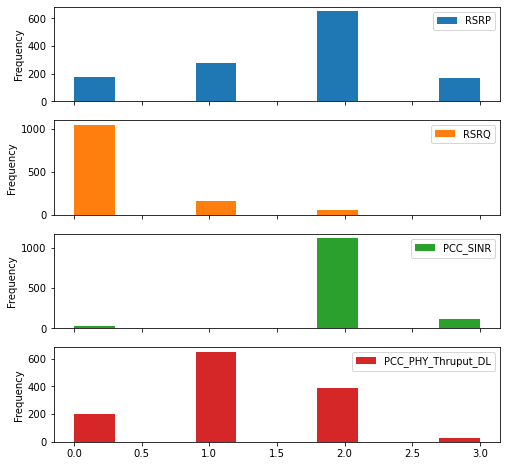

In [6]:
_ = df_binned.plot(subplots = True, kind = 'hist', figsize = (8,8))

### Verifying the Probability Distribution. 
Sum of all Probabilities should be 1.

In [7]:
df_prob_ = df_prob.copy()
Probabilities = recursion_mult(df_prob_)
print('Sum of Joint Probabilities is : {} '.format(Probabilities.sum()))

Sum of Probabilities is : 0.9999999999999998 


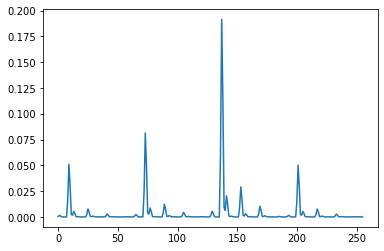

In [8]:
plt.plot(Probabilities)

In [21]:
df_prob.insert(0, 'States', ['Excellent', 'Good', 'Fair', 'Very Poor'])
df_prob

,States,P(PCC_PHY_Thruput_DL = x),P(PCC_SINR = x),P(RSRQ = x),P(RSRP = x)
0,Excellent,0.157604,0.025217,0.827423,0.136328
1,Good,0.513002,0.000000,0.125296,0.217494
2,Fair,0.305753,0.881009,0.044917,0.512214
3,Very Poor,0.023641,0.093775,0.002364,0.133964


### Verficiation

In [10]:
for target_col in df_prob.columns[1:]:
    print('Sum for Col {} is : {}'.format(target_col, df_prob[target_col].unique().sum()))

Sum for Col P(PCC_PHY_Thruput_DL = x) is : 1.0
Sum for Col P(PCC_SINR = x) is : 1.0
Sum for Col P(RSRQ = x) is : 0.9999999999999999
Sum for Col P(RSRP = x) is : 1.0


['RSRP', 'RSRQ', 'SINR', 'Thruput']
[('RSRP', 'RSRQ'), ('RSRP', 'SINR'), ('RSRQ', 'SINR'), ('RSRQ', 'Thruput'), ('SINR', 'Thruput')]


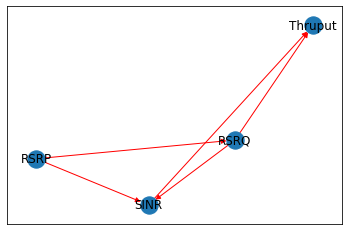

In [13]:

A = "RSRP"
B = "RSRQ"
C = "SINR"
D = "Thruput"

G = nx.DiGraph()
G.add_node(A)
G.add_node(B)
G.add_node(C)
G.add_node(D) 
G.add_edge(A,B)
G.add_edge(A,C)
G.add_edge(B,C)
G.add_edge(C,D)
G.add_edge(B,D)

print(G.nodes())
print(G.edges())


pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows = True)

plt.show()